In [13]:
import os
import re
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, Dense, Flatten, MaxPooling1D, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, r2_score
import joblib  # For saving scaler
import matplotlib.pyplot as plt

In [14]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)  # Prevent memory overflow
        print("✅ GPU is enabled!")
    except RuntimeError as e:
        print(e)


Physical devices cannot be modified after being initialized


In [15]:
# Paths
processed_folder = "split_output"  # Folder containing CSV files
subject_info_path = "subject_info.csv"  # Subject info file
model_save_path = "hemoglobin_cnn_model.h5"  # Path to save the trained model
scaler_save_path = "scaler.pkl"  # Path to save the scaler
predictions_save_path = "predictions.csv"  # Path to save predictions

In [16]:
# Load subject data
subjects_df = pd.read_csv(subject_info_path)

# Convert Gender to numeric (Male=1, Female=0)
label_encoder = LabelEncoder()
subjects_df["Gender"] = label_encoder.fit_transform(subjects_df["Gender"])

# Initialize dataset list
all_data = []

# Regular expression to extract ID from filename (assumes filenames like "1234_data.csv")
id_pattern = re.compile(r"(\d+)")  # Looks for numbers in the filename

# Process each CSV file
for file in os.listdir(processed_folder):
    if file.endswith(".csv"):
        file_path = os.path.join(processed_folder, file)

        # Extract ID from filename
        match = id_pattern.search(file)
        if match:
            file_id = int(match.group(1))  # Convert ID to integer
            print(f"Processing file: {file} (ID: {file_id})")  # Debugging line

            # Read the processed CSV file
            df = pd.read_csv(file_path)

            # Find the corresponding subject data
            subject_row = subjects_df[subjects_df["id"] == file_id]
            
            if not subject_row.empty:
                # Merge subject data with CSV data
                subject_repeated = pd.concat([subject_row] * len(df), ignore_index=True)
                merged_df = pd.concat([df.reset_index(drop=True), subject_repeated.reset_index(drop=True)], axis=1)
                all_data.append(merged_df)
            else:
                print(f"⚠️ Skipping {file}: No matching ID in subject info!")

# Ensure data exists before concatenation
if not all_data:
    raise ValueError("❌ No valid CSV files found! Check file formats and ID matching.")

# Combine all data
data = pd.concat(all_data, ignore_index=True)


Processing file: subject_28_part5.csv (ID: 28)
Processing file: subject_40_part2.csv (ID: 40)
Processing file: subject_25_part6.csv (ID: 25)
Processing file: subject_6_part4.csv (ID: 6)
Processing file: subject_52_part5.csv (ID: 52)
Processing file: subject_37_part1.csv (ID: 37)
Processing file: subject_23_part1.csv (ID: 23)
Processing file: subject_46_part5.csv (ID: 46)
Processing file: subject_31_part6.csv (ID: 31)
Processing file: subject_54_part2.csv (ID: 54)
Processing file: subject_54_part3.csv (ID: 54)
Processing file: subject_10_part6.csv (ID: 10)
Processing file: subject_46_part4.csv (ID: 46)
Processing file: subject_52_part4.csv (ID: 52)
Processing file: subject_6_part5.csv (ID: 6)
Processing file: subject_40_part3.csv (ID: 40)
Processing file: subject_16_part1.csv (ID: 16)
Processing file: subject_28_part4.csv (ID: 28)
Processing file: subject_16_part3.csv (ID: 16)
Processing file: subject_28_part6.csv (ID: 28)
Processing file: subject_40_part1.csv (ID: 40)
Processing file: 

In [ ]:
# Define features and target
X = data.drop(columns=["id", "Hemoglobin(g/L)"])  # Drop ID and target
y = data["Hemoglobin(g/L)"]  # Target variable

# Normalize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Save the scaler for future predictions
joblib.dump(scaler, scaler_save_path)
print(f"✅ Scaler saved to {scaler_save_path}")

# Reshape X for CNN: (samples, timesteps, features)
X_reshaped = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

# Build the 1D CNN Model
model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation="relu", input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    Flatten(),
    Dense(64, activation="relu"),
    Dense(32, activation="relu"),
    Dense(1)  # Regression output for Hemoglobin prediction
])

# Compile the model
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Save the trained model
model.save(model_save_path)
print(f"✅ Model saved to {model_save_path}")

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)

# Calculate R^2 score
r2 = r2_score(y_test, y_pred)

# Print performance metrics
print(f"Test MAE: {mae:.4f}")
print(f"Test R^2: {r2:.4f}")



✅ Scaler saved to scaler.pkl
Epoch 1/50


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17400/17400 ━━━━━━━━━━━━━━━━━━━━ 204s 12ms/step - loss: 879.8787 - mae: 17.9760 - val_loss: 217.3620 - val_mae: 11.8035
Epoch 2/50
17400/17400 ━━━━━━━━━━━━━━━━━━━━ 179s 10ms/step - loss: 2256.7981 - mae: 28.8810 - val_loss: 1917.7394 - val_mae: 37.1312
Epoch 3/50
17400/17400 ━━━━━━━━━━━━━━━━━━━━ 171s 10ms/step - loss: 8124.5303 - mae: 47.3296 - val_loss: 639674.8750 - val_mae: 627.9141
Epoch 4/50
17400/17400 ━━━━━━━━━━━━━━━━━━━━ 171s 10ms/step - loss: 23109.2637 - mae: 63.0679 - val_loss: 35505.2539 - val_mae: 164.5011
Epoch 5/50
17400/17400 ━━━━━━━━━━━━━━━━━━━━ 171s 10ms/step - loss: 37867.1172 - mae: 78.7234 - val_loss: 2584.8916 - val_mae: 41.6661
Epoch 6/50
17400/17400 ━━━━━━━━━━━━━━━━━━━━ 172s 10ms/step - loss: 53286.0273 - mae: 93.0079 - val_loss: 2188.8535 - val_mae: 35.9952


✅ Model saved to hemoglobin_cnn_model.h5
4350/4350 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 217.8340 - mae: 11.8243
4350/4350 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
Test MAE: 11.8035
Test R^2: 0.0430


✅ Predictions saved to predictions.csv


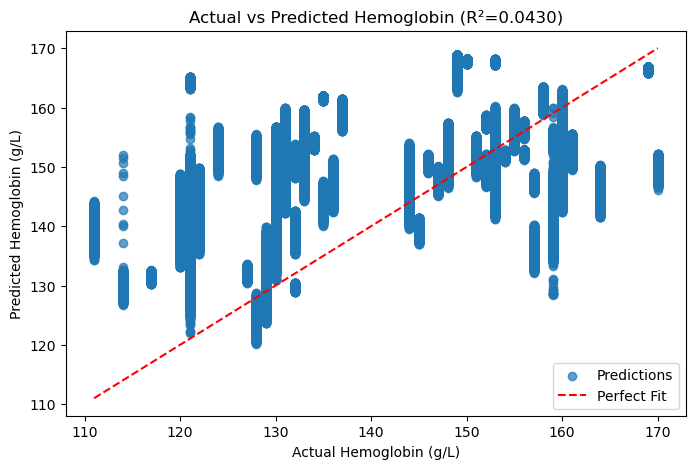

ModuleNotFoundError: No module named 'ace_tools'

In [18]:
# Save predictions to a CSV file
predictions_df = pd.DataFrame({"Actual": y_test.values, "Predicted": y_pred.flatten()})
predictions_df.to_csv(predictions_save_path, index=False)
print(f"✅ Predictions saved to {predictions_save_path}")

# Plot Actual vs Predicted
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.7, label="Predictions")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle="dashed", color="red", label="Perfect Fit")
plt.xlabel("Actual Hemoglobin (g/L)")
plt.ylabel("Predicted Hemoglobin (g/L)")
plt.title(f"Actual vs Predicted Hemoglobin (R²={r2:.4f})")
plt.legend()
plt.show()

# Display predictions
import ace_tools as tools
tools.display_dataframe_to_user(name="Hemoglobin Predictions", dataframe=predictions_df)


In [ ]:
import os
import re
import pandas as pd
import numpy as np

# Define paths
processed_folder = "processed_2Wavelenghts"  # Folder with extracted CSV files
split_folder = "split_output"  # New folder to store the divided CSVs
os.makedirs(split_folder, exist_ok=True)  # Create folder if it doesn't exist

# Regular expression to extract ID from filename (assumes filenames like "1234_data.csv")
id_pattern = re.compile(r"(\d+)")  # Looks for numbers in the filename

# Process each CSV file
for file in os.listdir(processed_folder):
    if file.endswith(".csv"):
        file_path = os.path.join(processed_folder, file)

        # Extract ID from filename
        match = id_pattern.search(file)
        if match:
            file_id = match.group(1)  # Extract ID as a string
            print(f"Processing file: {file} (ID: {file_id})")  # Debugging

            # Read CSV
            df = pd.read_csv(file_path)

            # Split into 6 parts
            split_size = len(df) // 6  # Number of rows per part
            if split_size == 0:  # Handle cases with fewer than 6 rows
                split_size = 1

            for i in range(6):
                start_idx = i * split_size
                end_idx = start_idx + split_size if i < 5 else len(df)  # Last part takes remaining rows

                # Extract subset
                df_part = df.iloc[start_idx:end_idx]

                # Save new file
                if not df_part.empty:
                    split_filename = os.path.join(split_folder, f"subject_{file_id}_part{i+1}.csv")
                    df_part.to_csv(split_filename, index=False)
                    print(f"✅ Saved: {split_filename}")

print("✅ All CSV files split into 6 parts successfully!")


Processing file: processed_50_PPGdata.csv (ID: 50)
✅ Saved: split_output/subject_50_part1.csv
✅ Saved: split_output/subject_50_part2.csv
✅ Saved: split_output/subject_50_part3.csv
✅ Saved: split_output/subject_50_part4.csv
✅ Saved: split_output/subject_50_part5.csv
✅ Saved: split_output/subject_50_part6.csv
Processing file: processed_9_PPGdata.csv (ID: 9)
✅ Saved: split_output/subject_9_part1.csv
✅ Saved: split_output/subject_9_part2.csv
✅ Saved: split_output/subject_9_part3.csv
✅ Saved: split_output/subject_9_part4.csv
✅ Saved: split_output/subject_9_part5.csv
✅ Saved: split_output/subject_9_part6.csv
Processing file: processed_20_PPGdata.csv (ID: 20)
✅ Saved: split_output/subject_20_part1.csv
✅ Saved: split_output/subject_20_part2.csv
✅ Saved: split_output/subject_20_part3.csv
✅ Saved: split_output/subject_20_part4.csv
✅ Saved: split_output/subject_20_part5.csv
✅ Saved: split_output/subject_20_part6.csv
Processing file: processed_12_PPGdata.csv (ID: 12)
✅ Saved: split_output/subject_

Physical devices cannot be modified after being initialized
